In [1]:
# Colab Cell 1: Mount Google Drive and Change Directory

from google.colab import drive
import os

print("Mounting Google Drive...")
drive.mount('/content/drive')
print("Google Drive mounted.")

# IMPORTANT: This path should point to your folder on Google Drive
# where you uploaded 'processed_for_modeling' and 'models' folders.
# Assuming you named that folder 'Colab_Task3_Files'
project_root = '/content/drive/My Drive/Colab_Task3_Files'

if os.path.exists(project_root):
    os.chdir(project_root)
    print(f"Changed current working directory to: {os.getcwd()}")
else:
    print(f"ERROR: Project root folder '{project_root}' not found. Please check the path in Google Drive.")
    print("Your current directory is:", os.getcwd())

# Verify the paths to data and models are now correct relative to the new working directory
# Based on your previous output, 'processed_for_modeling' is directly under project_root
data_path_check = 'processed_for_modeling'
models_path_check = 'models'

# Check if the project_root was successfully set as CWD
if os.getcwd() == project_root:
    if os.path.exists(data_path_check):
        print(f"Verified data path exists: {os.path.abspath(data_path_check)}")
    else:
        print(f"WARNING: Data path does NOT exist: {os.path.abspath(data_path_check)}. Check your Google Drive structure.")

    if os.path.exists(models_path_check):
        print(f"Verified models path exists: {os.path.abspath(models_path_check)}")
    else:
        print(f"WARNING: Models path does NOT exist: {os.path.abspath(models_path_check)}. Check your Google Drive structure.")
else:
    print("\nCRITICAL ERROR: Working directory was not successfully changed. File loading will fail.")
    print("Please ensure 'Colab_Task3_Files' is correctly placed and accessible in 'My Drive'.")

Mounting Google Drive...
Mounted at /content/drive
Google Drive mounted.
Changed current working directory to: /content/drive/My Drive/Colab_Task3_Files
Verified data path exists: /content/drive/My Drive/Colab_Task3_Files/processed_for_modeling
Verified models path exists: /content/drive/My Drive/Colab_Task3_Files/models


In [2]:
# Colab Cell: Verify Current Working Directory
print("Current working directory:")
!pwd


Current working directory:
/content/drive/My Drive/Colab_Task3_Files


In [3]:
# Colab Cell 2: Install Libraries

print("\nInstalling required libraries...")
!pip install shap
!pip install scikit-learn
!pip install pandas
!pip install numpy
!pip install scipy
!pip install matplotlib
!pip install seaborn
print("Libraries installed.")


Installing required libraries...
Libraries installed.


In [4]:
# Colab Cell: Verify Current Working Directory
print("Current working directory:")
!pwd

Current working directory:
/content/drive/MyDrive/Colab_Task3_Files


In [5]:
# Colab Cell 3: Import Libraries and Load Data (and Best Models) - WITH EXTENSIVE DEBUGGING
# -------------------------------------------------------------------------------------------

import pandas as pd
import numpy as np # Ensure numpy is imported here
import os
import scipy.sparse
import joblib # Import joblib for loading models

import shap
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') # Suppress warnings for cleaner output

print("\n--- Starting Task 3: Model Explainability ---")
print("Loading processed data and saved best models...")

# Define directories (paths are now relative to your project_root set in Cell 1)
data_dir = 'processed_for_modeling'
model_dir = 'models'

print("\n--- Attempting to load fraud data (sparse) ---")
X_train_fraud = None
X_test_fraud = None
y_train_fraud = None
y_test_fraud = None

try:
    print("Step 3.1: Loading X_train_fraud.npz...")
    X_train_fraud_loaded = scipy.sparse.load_npz(os.path.join(data_dir, 'X_train_fraud.npz'))
    X_train_fraud = X_train_fraud_loaded.astype(np.float32).tocsr()
    print(f"Step 3.1: X_train_fraud loaded. Shape: {X_train_fraud.shape}, Non-zero elements: {X_train_fraud.nnz}, Size (MB approx): {X_train_fraud.data.nbytes / (1024*1024):.2f} for data part.")

    print("Step 3.2: Loading X_test_fraud.npz...")
    X_test_fraud_loaded = scipy.sparse.load_npz(os.path.join(data_dir, 'X_test_fraud.npz'))
    X_test_fraud = X_test_fraud_loaded.astype(np.float32).tocsr()
    print(f"Step 3.2: X_test_fraud loaded. Shape: {X_test_fraud.shape}, Non-zero elements: {X_test_fraud.nnz}, Size (MB approx): {X_test_fraud.data.nbytes / (1024*1024):.2f} for data part.")

    print("Step 3.3: Loading y_train_fraud.csv and y_test_fraud.csv...")
    y_train_fraud = pd.read_csv(os.path.join(data_dir, 'y_train_fraud.csv')).squeeze()
    y_test_fraud = pd.read_csv(os.path.join(data_dir, 'y_test_fraud.csv')).squeeze()
    print("Step 3.3: Fraud target data loaded.")

except Exception as e:
    print(f"ERROR LOADING FRAUD DATA: {e}")
    print("Fraud data loading failed. Skipping fraud model operations.")


print("\n--- Attempting to load credit data (dense) ---")
X_train_credit = None
X_test_credit = None
y_train_credit = None
y_test_credit = None

try:
    print("Step 3.4: Loading X_train_credit.npy...")
    X_train_credit_loaded = np.load(os.path.join(data_dir, 'X_train_credit.npy'), allow_pickle=True)
    X_train_credit = X_train_credit_loaded.astype(np.float32)
    print(f"Step 3.4: X_train_credit loaded. Shape: {X_train_credit.shape}, Size (MB approx): {X_train_credit.nbytes / (1024*1024):.2f}.")

    print("Step 3.5: Loading X_test_credit.npy...")
    X_test_credit_loaded = np.load(os.path.join(data_dir, 'X_test_credit.npy'), allow_pickle=True)
    X_test_credit = X_test_credit_loaded.astype(np.float32)
    print(f"Step 3.5: X_test_credit loaded. Shape: {X_test_credit.shape}, Size (MB approx): {X_test_credit.nbytes / (1024*1024):.2f}.")

    print("Step 3.6: Loading y_train_credit.csv and y_test_credit.csv...")
    y_train_credit = pd.read_csv(os.path.join(data_dir, 'y_train_credit.csv')).squeeze()
    y_test_credit = pd.read_csv(os.path.join(data_dir, 'y_test_credit.csv')).squeeze()
    print("Step 3.6: Credit target data loaded.")

except Exception as e:
    print(f"ERROR LOADING CREDIT DATA: {e}")
    print("Credit data loading failed. Skipping credit model operations.")


print("\n--- Attempting to Load Best Models ---")
rf_fraud_model = None # Initialize to None
rf_credit_model = None # Initialize to None

try:
    # Load Fraud Model (Random Forest)
    fraud_model_path = os.path.join(model_dir, 'random_forest_fraud_model.joblib')
    print(f"Step 3.7: Loading fraud model from: {fraud_model_path}")
    rf_fraud_model = joblib.load(fraud_model_path)
    print("Step 3.7: Fraud Random Forest model loaded.")
    print(f"Step 3.7: Type of loaded fraud model: {type(rf_fraud_model)}") # Verify type
except Exception as e:
    print(f"ERROR LOADING FRAUD MODEL: {e}")
    print("Fraud model loading failed. rf_fraud_model will be None.")

try:
    # Load Credit Model (Random Forest)
    credit_model_path = os.path.join(model_dir, 'random_forest_credit_model.joblib')
    print(f"Step 3.8: Loading credit model from: {credit_model_path}")
    rf_credit_model = joblib.load(credit_model_path)
    print("Step 3.8: Credit Random Forest model loaded.")
    print(f"Step 3.8: Type of loaded credit model: {type(rf_credit_model)}") # Verify type
except Exception as e:
    print(f"ERROR LOADING CREDIT MODEL: {e}")
    print("Credit model loading failed. rf_credit_model will be None.")


# --- Prepare Feature Names for SHAP Plots ---
# Check if X_train_fraud and X_train_credit were loaded successfully
num_fraud_features = X_train_fraud.shape[1] if X_train_fraud is not None else 0
fraud_feature_names = [f'feature_{i}' for i in range(num_fraud_features)]

num_credit_features = X_train_credit.shape[1] if X_train_credit is not None else 0
credit_feature_names = [f'feature_{i}' for i in range(num_credit_features)]

print(f"\nFraud data has {num_fraud_features} features (using generic names for plots).")
print(f"Credit data has {num_credit_features} features (using generic names for plots).")

print("\n--- End of Colab Cell 3 execution. ---")


--- Starting Task 3: Model Explainability ---
Loading processed data and saved best models...

--- Attempting to load fraud data (sparse) ---
Step 3.1: Loading X_train_fraud.npz...
Step 3.1: X_train_fraud loaded. Shape: (191744, 309466), Non-zero elements: 3323542, Size (MB approx): 12.68 for data part.
Step 3.2: Loading X_test_fraud.npz...
Step 3.2: X_test_fraud loaded. Shape: (45334, 309466), Non-zero elements: 594327, Size (MB approx): 2.27 for data part.
Step 3.3: Loading y_train_fraud.csv and y_test_fraud.csv...
Step 3.3: Fraud target data loaded.

--- Attempting to load credit data (dense) ---
Step 3.4: Loading X_train_credit.npy...
Step 3.4: X_train_credit loaded. Shape: (662, 39), Size (MB approx): 0.10.
Step 3.5: Loading X_test_credit.npy...
Step 3.5: X_test_credit loaded. Shape: (85118, 39), Size (MB approx): 12.66.
Step 3.6: Loading y_train_credit.csv and y_test_credit.csv...
Step 3.6: Credit target data loaded.

--- Attempting to Load Best Models ---
Step 3.7: Loading frau


--- Calculating Random Forest Feature Importances for Fraud Data (Not SHAP) ---
Top 20 features by Random Forest Importance (Fraud Data):
               Feature  Importance
10          feature_10    0.127584
7            feature_7    0.106952
309455  feature_309455    0.012772
6            feature_6    0.011972
309285  feature_309285    0.007897
5            feature_5    0.007818
309283  feature_309283    0.007497
2            feature_2    0.007337
3            feature_3    0.007235
309287  feature_309287    0.007204
4            feature_4    0.007187
1            feature_1    0.007046
309282  feature_309282    0.006398
309284  feature_309284    0.005964
309280  feature_309280    0.005474
0            feature_0    0.005376
309323  feature_309323    0.005087
309288  feature_309288    0.004885
309281  feature_309281    0.004639
309289  feature_309289    0.004308


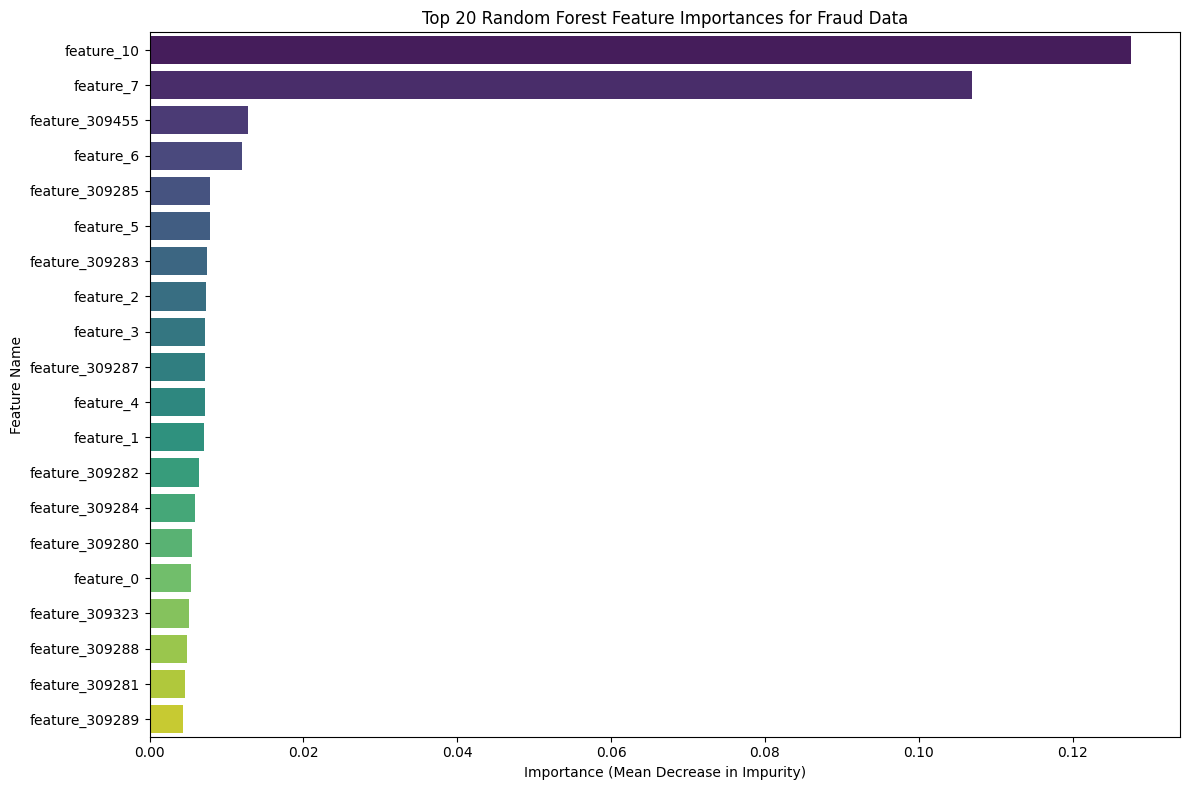


--- Interpretation of Random Forest Feature Importances ---
These importances indicate how much each feature contributed to reducing impurity (e.g., Gini impurity) in the decision trees.
Higher importance means the feature was more impactful in making splits in the trees.
However, remember these are NOT SHAP values. They don't tell you the direction of impact (positive/negative) on fraud probability, nor are they as robust for feature interactions or local explanations.


In [6]:
# Colab Cell: Calculate and Plot Random Forest Feature Importances (Fraud Data - Non-SHAP)
# -----------------------------------------------------------------------------------------

if rf_fraud_model is not None:
    print("\n--- Calculating Random Forest Feature Importances for Fraud Data (Not SHAP) ---")

    # Access the built-in feature importances from your trained Random Forest model
    feature_importances_fraud = rf_fraud_model.feature_importances_

    # Create a DataFrame for easier sorting and plotting
    importance_df_fraud = pd.DataFrame({
        'Feature': fraud_feature_names,
        'Importance': feature_importances_fraud
    })

    # Sort by importance in descending order and select top N
    top_n_features = 20 # You can adjust this number
    importance_df_fraud = importance_df_fraud.sort_values(by='Importance', ascending=False).head(top_n_features)

    print(f"Top {top_n_features} features by Random Forest Importance (Fraud Data):")
    print(importance_df_fraud)

    # Plotting the feature importances
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df_fraud, palette='viridis')
    plt.title(f'Top {top_n_features} Random Forest Feature Importances for Fraud Data')
    plt.xlabel('Importance (Mean Decrease in Impurity)')
    plt.ylabel('Feature Name')
    plt.tight_layout()
    plt.show()

    print("\n--- Interpretation of Random Forest Feature Importances ---")
    print("These importances indicate how much each feature contributed to reducing impurity (e.g., Gini impurity) in the decision trees.")
    print("Higher importance means the feature was more impactful in making splits in the trees.")
    print("However, remember these are NOT SHAP values. They don't tell you the direction of impact (positive/negative) on fraud probability, nor are they as robust for feature interactions or local explanations.")
else:
    print("\nSkipping fraud feature importance calculation: Fraud model not loaded successfully.")

In [11]:
# Colab Cell: SHAP Explainer Initialization and Explanation Generation (Credit Data) - REVISED DEBUGGING
# ----------------------------------------------------------------------------

if rf_credit_model is not None and X_train_credit is not None and X_test_credit is not None:
    print("\n--- Generating SHAP explanations for Credit Data (Random Forest) ---")

    # Debugging: Print initial data shapes
    print(f"DEBUG: X_train_credit.shape: {X_train_credit.shape}")
    print(f"DEBUG: X_test_credit.shape: {X_test_credit.shape}")

    # Determine background sample size: Take minimum of 1000 or available X_train_credit samples
    background_sample_size_credit = min(1000, X_train_credit.shape[0])
    if background_sample_size_credit == 0:
        print("WARNING: X_train_credit is empty. Cannot generate SHAP background sample.")
        # Exit this block if data is empty
        rf_credit_model = None # Set to None to trigger skipping subsequent SHAP cells
    else:
        sample_indices_background_credit = np.random.choice(
            X_train_credit.shape[0],
            background_sample_size_credit, # Use the dynamic sample size
            replace=False
        )
        background_credit = X_train_credit[sample_indices_background_credit]

        print(f"DEBUG: Background credit data shape (used for explainer): {background_credit.shape}, dtype: {background_credit.dtype}")

        explainer_credit = shap.TreeExplainer(rf_credit_model, data=background_credit, model_output='probability')

        # Determine test sample size: Take minimum of 5000 or available X_test_credit samples
        sample_size_test_credit = min(5000, X_test_credit.shape[0])
        if sample_size_test_credit == 0:
            print("WARNING: X_test_credit is empty. Cannot generate SHAP test sample.")
            # Exit this block if data is empty
            rf_credit_model = None # Set to None to trigger skipping subsequent SHAP cells
        else:
            sample_indices_credit = np.random.choice(
                X_test_credit.shape[0],
                sample_size_test_credit, # Use the dynamic sample size
                replace=False
            )
            X_test_credit_sample = X_test_credit[sample_indices_credit]

            # Debugging: Check input shape to shap.values
            print(f"DEBUG: X_test_credit_sample shape (input to explainer.shap_values): {X_test_credit_sample.shape}, dtype: {X_test_credit_sample.dtype}")

            print(f"Calculating SHAP values for {sample_size_test_credit} credit test samples...")
            shap_values_credit = explainer_credit.shap_values(X_test_credit_sample)

            # Debugging: Check raw output of explainer.shap_values
            print(f"DEBUG: Raw shap_values_credit type: {type(shap_values_credit)}")
            if isinstance(shap_values_credit, list):
                print(f"DEBUG: shap_values_credit is a list. Length: {len(shap_values_credit)}")
                if len(shap_values_credit) > 0:
                    print(f"DEBUG: shap_values_credit[0] shape: {shap_values_credit[0].shape}")
                if len(shap_values_credit) > 1:
                    print(f"DEBUG: shap_values_credit[1] shape: {shap_values_credit[1].shape}")
            else:
                print(f"DEBUG: shap_values_credit is NOT a list. Shape: {shap_values_credit.shape}")


            X_test_credit_sample_df = pd.DataFrame(X_test_credit_sample, columns=credit_feature_names)

            print("SHAP values for Credit Data generated.")

else:
    print("\nSkipping SHAP explanation for Credit Data: Model or data not loaded successfully.")


--- Generating SHAP explanations for Credit Data (Random Forest) ---
DEBUG: X_train_credit.shape: (662, 39)
DEBUG: X_test_credit.shape: (85118, 39)
DEBUG: Background credit data shape (used for explainer): (662, 39), dtype: float32
DEBUG: X_test_credit_sample shape (input to explainer.shap_values): (5000, 39), dtype: float32
Calculating SHAP values for 5000 credit test samples...


 99%|===================| 9930/10000 [01:16<00:00]       

DEBUG: Raw shap_values_credit type: <class 'numpy.ndarray'>
DEBUG: shap_values_credit is NOT a list. Shape: (5000, 39, 2)
SHAP values for Credit Data generated.


In [15]:
# Colab Cell: SHAP Explainer Initialization and Explanation Generation (Credit Data) - REVISED DEBUGGING AND DATAFRAME CONVERSION
# ----------------------------------------------------------------------------

if rf_credit_model is not None and X_train_credit is not None and X_test_credit is not None:
    print("\n--- Generating SHAP explanations for Credit Data (Random Forest) ---")

    # Debugging: Print initial data shapes
    print(f"DEBUG: X_train_credit.shape: {X_train_credit.shape}")
    print(f"DEBUG: X_test_credit.shape: {X_test_credit.shape}")

    # Verify model's expected feature count
    # n_features_in_ is standard for scikit-learn >= 0.24
    if hasattr(rf_credit_model, 'n_features_in_'):
        print(f"DEBUG: rf_credit_model.n_features_in_ (model's expected input features): {rf_credit_model.n_features_in_}")
    # n_features_ is older but might be present
    if hasattr(rf_credit_model, 'n_features_'):
        print(f"DEBUG: rf_credit_model.n_features_ (model's feature count): {rf_credit_model.n_features_}")


    # Determine background sample size: Take minimum of 1000 or available X_train_credit samples
    background_sample_size_credit = min(1000, X_train_credit.shape[0])
    if background_sample_size_credit == 0:
        print("WARNING: X_train_credit is empty. Cannot generate SHAP background sample.")
        rf_credit_model = None # Set to None to trigger skipping subsequent SHAP cells
    else:
        sample_indices_background_credit = np.random.choice(
            X_train_credit.shape[0],
            background_sample_size_credit, # Use the dynamic sample size
            replace=False
        )
        background_credit = X_train_credit[sample_indices_background_credit]

        print(f"DEBUG: Background credit data shape (raw numpy array): {background_credit.shape}, dtype: {background_credit.dtype}")

        # Convert background_credit to DataFrame for SHAP explainer
        # Ensure feature_names match the actual number of columns in background_credit
        current_background_feature_names = credit_feature_names[:background_credit.shape[1]]
        background_credit_df = pd.DataFrame(background_credit, columns=current_background_feature_names)
        print(f"DEBUG: Background credit data (DataFrame input to explainer) shape: {background_credit_df.shape}, dtypes: {background_credit_df.dtypes.unique()}")


        explainer_credit = shap.TreeExplainer(rf_credit_model, data=background_credit_df, model_output='probability') # Pass DataFrame

        # Determine test sample size: Take minimum of 5000 or available X_test_credit samples
        sample_size_test_credit = min(5000, X_test_credit.shape[0])
        if sample_size_test_credit == 0:
            print("WARNING: X_test_credit is empty. Cannot generate SHAP test sample.")
            rf_credit_model = None # Set to None to trigger skipping subsequent SHAP cells
        else:
            sample_indices_credit = np.random.choice(
                X_test_credit.shape[0],
                sample_size_test_credit, # Use the dynamic sample size
                replace=False
            )
            X_test_credit_sample = X_test_credit[sample_indices_credit]

            # Convert X_test_credit_sample to DataFrame for SHAP explanation calculation
            # Ensure feature_names match the actual number of columns in X_test_credit_sample
            current_test_sample_feature_names = credit_feature_names[:X_test_credit_sample.shape[1]]
            X_test_credit_sample_df_input = pd.DataFrame(X_test_credit_sample, columns=current_test_sample_feature_names)
            print(f"DEBUG: X_test_credit_sample (DataFrame input to explainer.shap_values) shape: {X_test_credit_sample_df_input.shape}, dtypes: {X_test_credit_sample_df_input.dtypes.unique()}")


            print(f"Calculating SHAP values for {sample_size_test_credit} credit test samples...")
            shap_values_credit = explainer_credit.shap_values(X_test_credit_sample_df_input) # Pass DataFrame

            # Debugging: Check raw output of explainer.shap_values
            print(f"DEBUG: Raw shap_values_credit type: {type(shap_values_credit)}")
            if isinstance(shap_values_credit, list):
                print(f"DEBUG: shap_values_credit is a list. Length: {len(shap_values_credit)}")
                if len(shap_values_credit) > 0:
                    print(f"DEBUG: shap_values_credit[0] shape: {shap_values_credit[0].shape}")
                if len(shap_values_credit) > 1:
                    print(f"DEBUG: shap_values_credit[1] shape: {shap_values_credit[1].shape}")
                # Add a sanity check
                if len(shap_values_credit) > 1 and shap_values_credit[1].shape[1] != X_test_credit_sample_df_input.shape[1]:
                    print("CRITICAL WARNING: SHAP values (positive class) feature count does NOT match input data feature count!")
            else:
                print(f"DEBUG: shap_values_credit is NOT a list. Shape: {shap_values_credit.shape}")


            # This DataFrame is used by the summary_plot, so ensure it has the correct feature names
            # It's based on X_test_credit_sample, which should have the full 39 features
            X_test_credit_sample_df = pd.DataFrame(X_test_credit_sample, columns=credit_feature_names) # Use full feature names here if X_test_credit_sample has all 39

            print("SHAP values for Credit Data generated.")

else:
    print("\nSkipping SHAP explanation for Credit Data: Model or data not loaded successfully.")


--- Generating SHAP explanations for Credit Data (Random Forest) ---
DEBUG: X_train_credit.shape: (662, 39)
DEBUG: X_test_credit.shape: (85118, 39)
DEBUG: rf_credit_model.n_features_in_ (model's expected input features): 39
DEBUG: Background credit data shape (raw numpy array): (662, 39), dtype: float32
DEBUG: Background credit data (DataFrame input to explainer) shape: (662, 39), dtypes: [dtype('float32')]
DEBUG: X_test_credit_sample (DataFrame input to explainer.shap_values) shape: (5000, 39), dtypes: [dtype('float32')]
Calculating SHAP values for 5000 credit test samples...


100%|===================| 9966/10000 [01:17<00:00]       

DEBUG: Raw shap_values_credit type: <class 'numpy.ndarray'>
DEBUG: shap_values_credit is NOT a list. Shape: (5000, 39, 2)
SHAP values for Credit Data generated.



--- Generating SHAP Summary Plot for Credit Data ---
DEBUG: Shape of shap_values_for_plot (after slicing for class 1): (5000, 39)
Shape of X_test_credit_sample_df: (5000, 39)
Length of credit_feature_names: 39


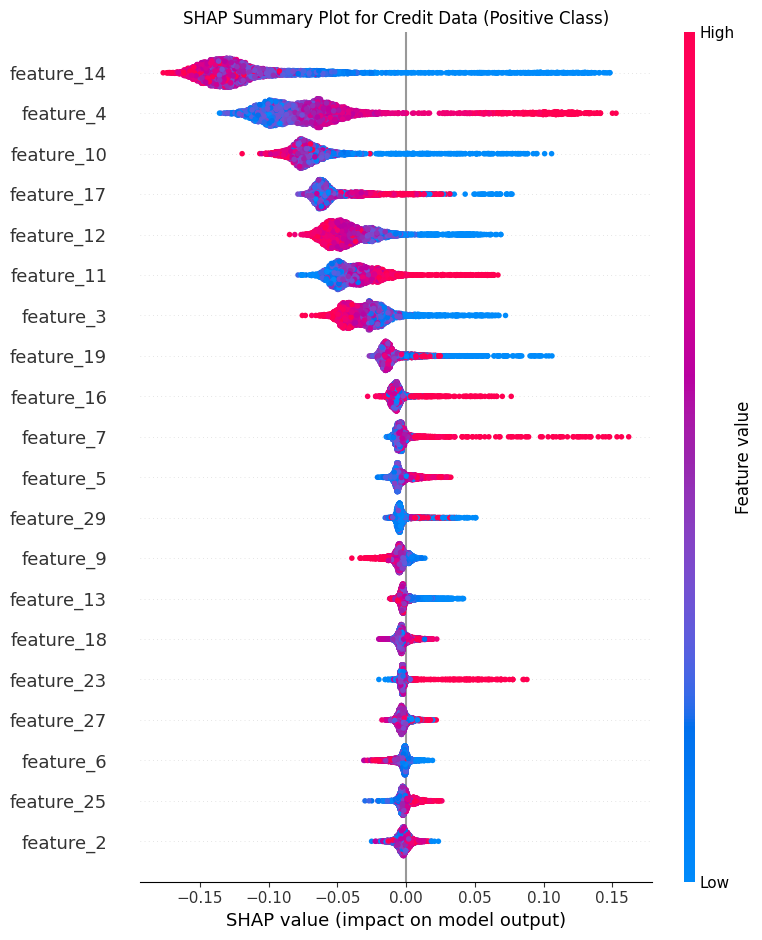

SHAP Summary Plot for Credit Data displayed.


In [17]:
# Colab Cell: SHAP Global Interpretation - Summary Plot (Credit Data) - REVISED
# ----------------------------------------------------------------

if 'shap_values_credit' in locals() and shap_values_credit is not None:
    print("\n--- Generating SHAP Summary Plot for Credit Data ---")

    # Access SHAP values for the positive class (class 1) across all samples and features
    # The shape is (samples, features, classes), so we slice to get all samples, all features, for class 1
    shap_values_for_plot = shap_values_credit[:, :, 1]

    # Debugging: Confirm the shape after slicing
    print(f"DEBUG: Shape of shap_values_for_plot (after slicing for class 1): {shap_values_for_plot.shape}")
    print(f"Shape of X_test_credit_sample_df: {X_test_credit_sample_df.shape}")
    print(f"Length of credit_feature_names: {len(credit_feature_names)}")


    shap.summary_plot(
        shap_values_for_plot, # Use the correctly sliced SHAP values
        X_test_credit_sample_df,
        feature_names=credit_feature_names,
        plot_type="dot",
        max_display=20,
        show=False
    )
    plt.title('SHAP Summary Plot for Credit Data (Positive Class)')
    plt.tight_layout()
    plt.show()

    print("SHAP Summary Plot for Credit Data displayed.")
else:
    print("\nSkipping SHAP Summary Plot for Credit Data: SHAP values not generated.")


--- Generating SHAP Force Plot for an Individual Credit Prediction ---
Explaining instance 2 (predicted as default).


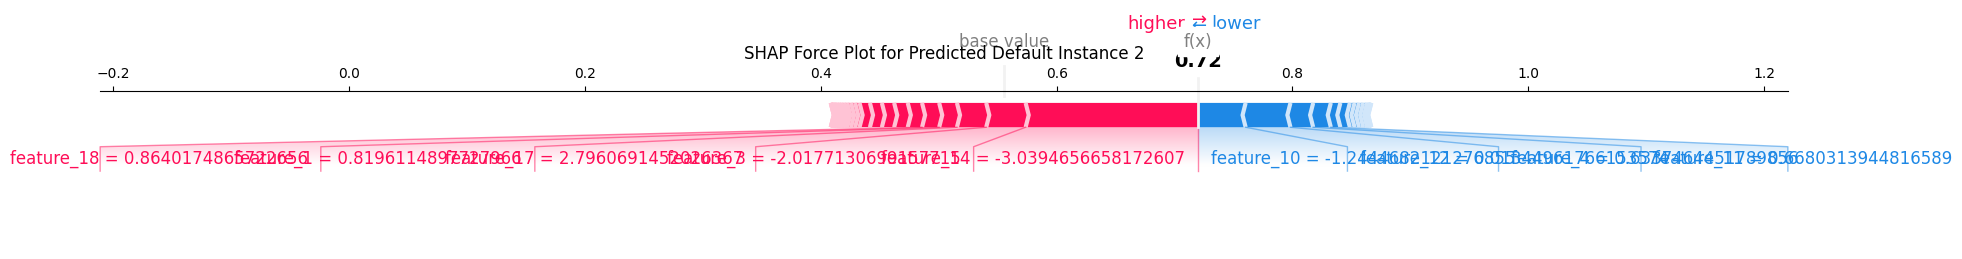


--- Generating SHAP Force Plot for an Individual Non-Default Prediction ---
Explaining instance 0 (predicted as non-default).


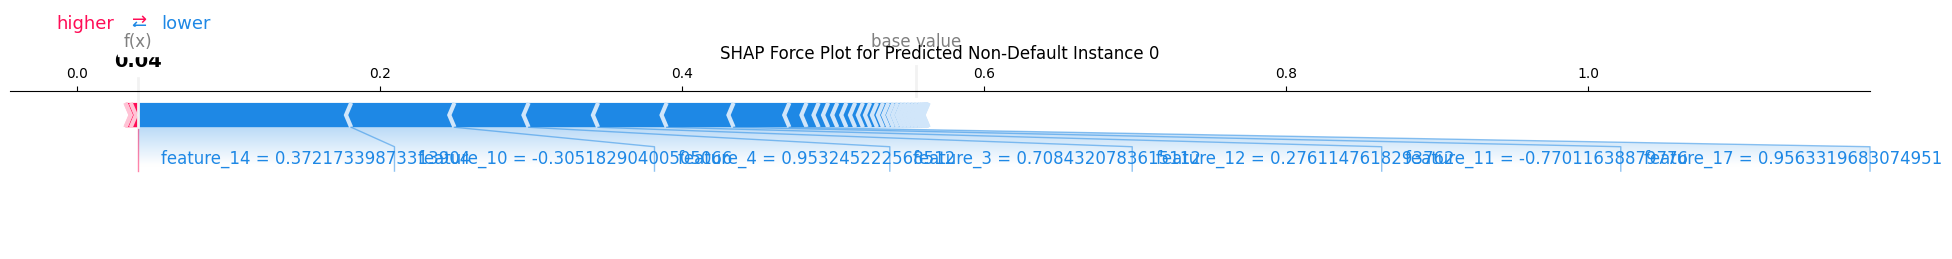

In [18]:
# Colab Cell: SHAP Local Interpretation - Force Plot (Individual Prediction - Credit Data) - REVISED
# ----------------------------------------------------------------------------------

if 'rf_credit_model' in locals() and rf_credit_model is not None and \
   'shap_values_credit' in locals() and shap_values_credit is not None and \
   'explainer_credit' in locals() and explainer_credit is not None: # Ensure explainer is available
    print("\n--- Generating SHAP Force Plot for an Individual Credit Prediction ---")

    # Get predictions on the sampled test data
    predictions = rf_credit_model.predict(X_test_credit_sample_df)

    predicted_default_indices = np.where(predictions == 1)[0]

    if len(predicted_default_indices) > 0:
        instance_to_explain_idx = predicted_default_indices[0]
        instance_data = X_test_credit_sample_df.iloc[instance_to_explain_idx]

        # Slice SHAP values for this specific instance and positive class
        shap_values_for_instance = shap_values_credit[instance_to_explain_idx, :, 1] # All features, for class 1

        print(f"Explaining instance {instance_to_explain_idx} (predicted as default).")
        shap.force_plot(
            explainer_credit.expected_value[1], # Access expected value for class 1
            shap_values_for_instance,
            instance_data,
            feature_names=credit_feature_names,
            matplotlib=True,
            show=False
        )
        plt.title(f'SHAP Force Plot for Predicted Default Instance {instance_to_explain_idx}')
        plt.tight_layout()
        plt.show()
    else:
        print("No instances predicted as default found in the sampled test set. Cannot generate a force plot for a predicted default.")
        print("Consider increasing 'sample_size_test_credit' or sampling actual default cases.")

    print("\n--- Generating SHAP Force Plot for an Individual Non-Default Prediction ---")
    predicted_non_default_indices = np.where(predictions == 0)[0]
    if len(predicted_non_default_indices) > 0:
        instance_to_explain_idx_nf = predicted_non_default_indices[0]
        instance_data_nf = X_test_credit_sample_df.iloc[instance_to_explain_idx_nf]

        # Slice SHAP values for this specific instance and positive class
        shap_values_for_instance_nf = shap_values_credit[instance_to_explain_idx_nf, :, 1] # All features, for class 1

        print(f"Explaining instance {instance_to_explain_idx_nf} (predicted as non-default).")
        shap.force_plot(
            explainer_credit.expected_value[1], # Access expected value for class 1
            shap_values_for_instance_nf,
            instance_data_nf,
            feature_names=credit_feature_names,
            matplotlib=True,
            show=False
        )
        plt.title(f'SHAP Force Plot for Predicted Non-Default Instance {instance_to_explain_idx_nf}')
        plt.tight_layout()
        plt.show()
    else:
        print("No instances predicted as non-default found in the sampled test set.")
else:
    print("\nSkipping SHAP Force Plots for Credit Data: Model or SHAP values not generated or explainer missing.")


--- Generating SHAP Dependence Plots for Credit Data ---
Generating dependence plot for: feature_12


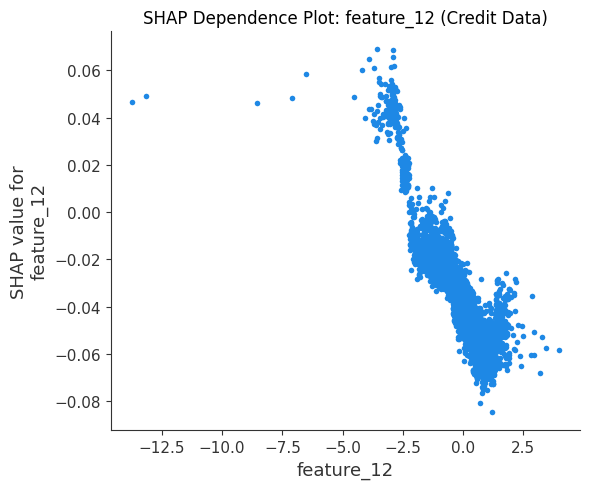

Generating dependence plot for: feature_17


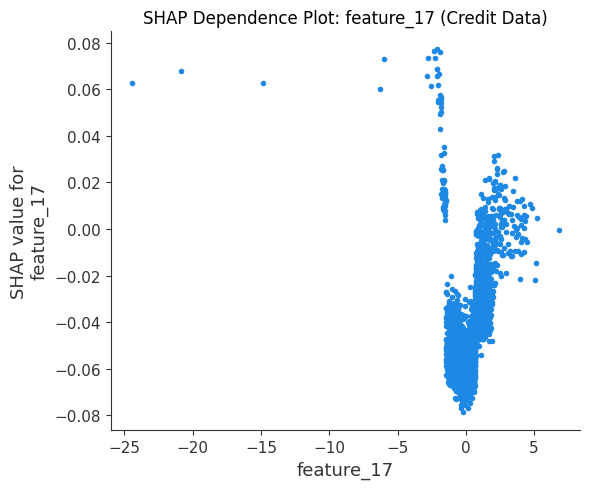

Generating dependence plot for: feature_10


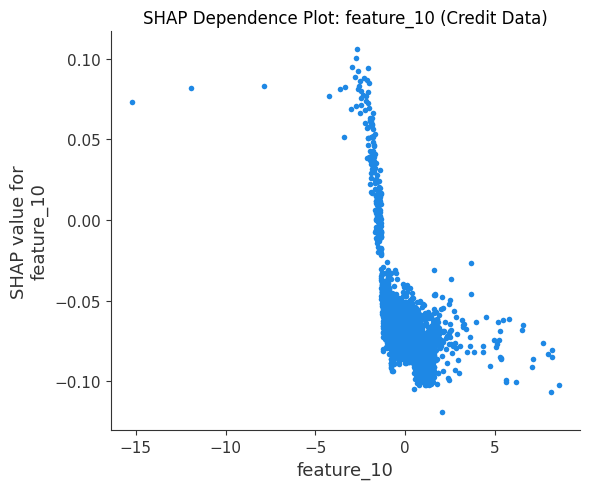

Generating dependence plot for: feature_4


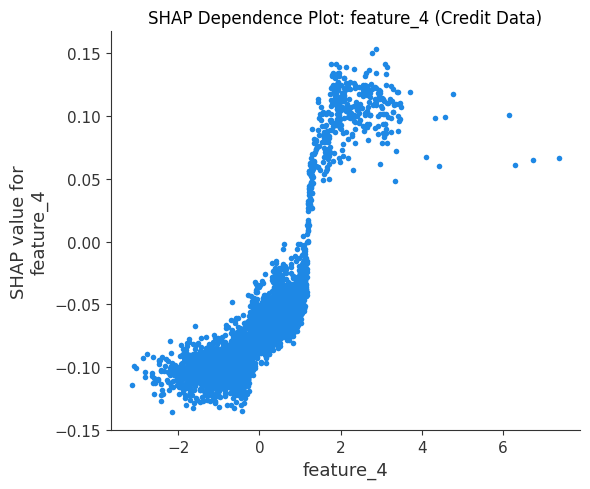

Generating dependence plot for: feature_14


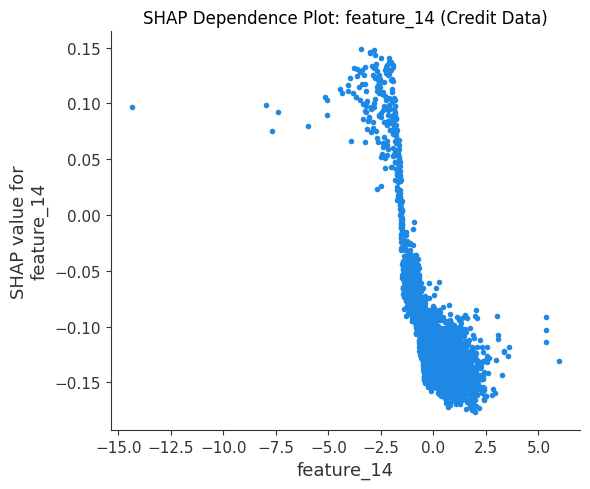

SHAP Dependence Plots for Credit Data displayed.


In [19]:
# Colab Cell: SHAP Global Interpretation - Dependence Plots (Credit Data) - REVISED
# ------------------------------------------------------------------

if 'shap_values_credit' in locals() and shap_values_credit is not None and X_test_credit_sample_df is not None:
    print("\n--- Generating SHAP Dependence Plots for Credit Data ---")

    # Use the correctly sliced SHAP values for the positive class (class 1)
    shap_values_for_plot = shap_values_credit[:, :, 1]

    # Get top features based on mean absolute SHAP value for the positive class
    top_feature_indices_credit = np.abs(shap_values_for_plot).mean(0).argsort()[-5:]
    top_features_for_dependence_credit = [credit_feature_names[i] for i in top_feature_indices_credit]

    for feature in top_features_for_dependence_credit:
        print(f"Generating dependence plot for: {feature}")
        shap.dependence_plot(
            feature,
            shap_values_for_plot, # Use the correctly sliced SHAP values
            X_test_credit_sample_df,
            interaction_index=None,
            show=False
        )
        plt.title(f'SHAP Dependence Plot: {feature} (Credit Data)')
        plt.tight_layout()
        plt.show()

    print("SHAP Dependence Plots for Credit Data displayed.")
else:
    print("\nSkipping SHAP Dependence Plots for Credit Data: SHAP values or sampled data not generated.")